# Interactive Training (CIFAR-10)

This notebook lets you configure, train, and visualize the CIFAR-10 model end-to-end.


### Objectives
- Achieve ≥ 85% test accuracy on CIFAR-10
- Keep parameters < 200k
- Ensure receptive field > 44
- Use C1C2C3C4 architecture without MaxPooling
- Include Depthwise Separable Conv (C2) and Dilated Convs (C3/C4)
- Use GAP, Albumentations (HF, ShiftScaleRotate, CoarseDropout)

### Key Features
- C1C2C3C4 network with dilations (d=2,4,8) and DW separable conv in C2
- Global Average Pooling + Linear head
- Albumentations pipeline with dataset mean/std
- OneCycleLR schedule (base lr=0.003, max_lr=0.2) for faster convergence
- Detailed metrics: train/test accuracy, train/test loss, LR curve
- Visualizations: training curves, per-class accuracy, misclassified images
- Interactive cells to override config, train, and analyze results


## Setup & Imports


In [1]:
!git clone https://github.com/SachinDangayach/AU_7_NN_CIFAR.git

Cloning into 'AU_7_NN_CIFAR'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 197 (delta 98), reused 163 (delta 64), pack-reused 0 (from 0)
Receiving objects: 100% (197/197), 636.90 KiB | 14.15 MiB/s, done.
Resolving deltas: 100% (98/98), done.


## Configure Training


In [2]:
# Interactive Training Notebook
# Use: Run cells top-to-bottom. Adjust config overrides in the next cell.
import os, sys

# Add the cloned repository directory to the Python path
# sys.path.append('/content/AU_7_NN_CIFAR')
sys.path.append('/kaggle/working/AU_7_NN_CIFAR')

from config import get_config, ProjectConfig
from src.data.data_manager import create_data_manager
from src.models.model import create_model
from src.training.trainer import create_trainer
from src.visualization.visualizer import create_visualizer

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = get_config()
config.training.device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {device}")
print(f"Batch size: {config.data.batch_size}")
print(f"Scheduler: {config.training.scheduler_type}, base LR={config.training.learning_rate}, max_lr={getattr(config.training,'max_lr', None)}")


Device: cuda
Batch size: 128
Scheduler: OneCycleLR, base LR=0.003, max_lr=0.2


## Data Loaders


In [3]:
# Optional: override some config values here
# Example: faster experimentation
config.training.max_epochs = 30
config.training.scheduler_type = 'OneCycleLR'
config.training.learning_rate = 0.003
config.training.max_lr = 0.2
config.training.post_target_extra_epochs = 3
config.training.target_test_accuracy = 85.0

# Print quick summary
from config import print_config
print_config(config)


Project: Advanced CIFAR-10 Classification v1.0.0
Author: ERA Student

Model Configuration:
  Input Channels: 3
  Number of Classes: 10
  Dropout Rate: 0.05
  Max Parameters: 200,000
  Min Receptive Field: 44

Data Configuration:
  Dataset: CIFAR10
  Batch Size: 128
  Data Root: ./data
  Normalization Mean: (0.49, 0.48, 0.45)
  Normalization Std: (0.25, 0.24, 0.26)

Training Configuration:
  Epochs: 50
  Learning Rate: 0.003
  Scheduler: OneCycleLR
  Target Accuracy: 85.0%

Augmentation Configuration:
  Horizontal Flip: 0.5
  ShiftScaleRotate: 0.5
  CoarseDropout: 0.3


## Model Summary


In [4]:
# Quick verification: run a dummy forward pass
if 'model' not in locals():
    model = create_model(config.model).to(device)

x = torch.randn(2, 3, 32, 32).to(device)
out = model(x)
print("Input:", tuple(x.shape), "Output:", tuple(out.shape))
assert out.shape[-1] == config.model.num_classes, "Output classes mismatch"
print("✅ Forward pass OK")


Input: (2, 3, 32, 32) Output: (2, 10)
✅ Forward pass OK


In [5]:
# Data
data_manager = create_data_manager(config.data)
# Optionally compute dataset stats (commented for speed)
# mean, std = data_manager.calculate_dataset_statistics()
train_t, test_t = data_manager.create_transforms()
train_ds, test_ds = data_manager.load_datasets(train_t, test_t)
train_loader, test_loader = data_manager.create_data_loaders(train_ds, test_ds)

print(len(train_loader), len(test_loader))


Creating transforms with normalization: mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26)
Loading CIFAR-10 datasets...


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/kaggle/working/AU_7_NN_CIFAR/src/data/data_manager.py:180: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s] 


Datasets loaded successfully:
  Training samples: 50000
  Test samples: 10000
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CUDA Available: True
Data loaders created:
  Training batches: 391
  Test batches: 79
  Batch size: 128
391 79


## Train


In [6]:
# Create model
model = create_model(config.model).to(device)

# Count parameters
from src.models.model import count_model_parameters
total_params = count_model_parameters(model)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Parameter requirement (< {config.model.max_parameters:,}): {'✓' if total_params < config.model.max_parameters else '✗'}")

# Display model summary
viz = create_visualizer(config.visualization)
viz.display_model_summary(model)



Model created successfully!
Total parameters: 162,458
Parameter requirement (< 200,000): ✓
MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvBlock-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
         Dropout2d-9           [-1, 16, 32, 32]               0
        ConvBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             144
           Conv2d-12           [-1, 32, 32, 32]  

In [7]:
# Print full model architecture summary
from src.visualization.visualizer import create_visualizer
if 'model' not in locals():
    model = create_model(config.model).to(device)
visualizer = create_visualizer(config.visualization)
visualizer.display_model_summary(model)


MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvBlock-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
         Dropout2d-9           [-1, 16, 32, 32]               0
        ConvBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             144
           Conv2d-12           [-1, 32, 32, 32]             512
DepthwiseSeparableConv-13           [-1, 32, 32, 32]               0
      B

## Training Curves


In [8]:
# Model and trainer
model = create_model(config.model).to(device)
trainer = create_trainer(model, config.training, device)

metrics = trainer.train(
    train_loader,
    test_loader,
    max_epochs=config.training.max_epochs,
    target_test_acc=config.training.target_test_accuracy,
    post_target_extra_epochs=config.training.post_target_extra_epochs,
)

best = metrics.get_best_metrics()
print("\nTraining completed!")
print(f"Best test accuracy: {best.get('best_test_accuracy', float('nan')):.2f}%")
print(f"Best epoch: {best.get('best_epoch', -1)}")


Epoch 1/50: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s, Train=24.36%, LR=0.013793]


Epoch 1/30: 100%|██████████| 391/391 [00:33<00:00,  11.70it/s, Train=24.36%,  Test=36.25%, LR=0.013793]


Epoch 2/50: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s, Train=36.12%, LR=0.030472]


Epoch 2/30: 100%|██████████| 391/391 [00:34<00:00,  11.32it/s, Train=36.12%,  Test=45.69%, LR=0.030472]


Epoch 3/50: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s, Train=45.05%, LR=0.056025]


Epoch 3/30: 100%|██████████| 391/391 [00:38<00:00,  10.22it/s, Train=45.05%,  Test=56.03%, LR=0.056025]


Epoch 4/50: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s, Train=52.55%, LR=0.087367]


Epoch 4/30: 100%|██████████| 391/391 [00:36<00:00,  10.72it/s, Train=52.55%,  Test=60.76%, LR=0.087367]


Epoch 5/50: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s, Train=58.04%, LR=0.120717]


Epoch 5/30: 100%|██████████| 391/391 [00:37<00:00,  10.53it/s, Train=58.04%,  Test=67.17%, LR=0.120717]


Epoch 6/50: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s, Train=62.25%, LR=0.152049]


Epoch 6/30: 100%|██████████| 391/391 [00:37<00:00,  10.56it/s, Train=62.25%,  Test=70.14%, LR=0.152049]


Epoch 7/50: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s, Train=66.09%, LR=0.177583]


Epoch 7/30: 100%|██████████| 391/391 [00:36<00:00,  10.64it/s, Train=66.09%,  Test=72.51%, LR=0.177583]


Epoch 8/50: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s, Train=68.46%, LR=0.194237]


Epoch 8/30: 100%|██████████| 391/391 [00:37<00:00,  10.53it/s, Train=68.46%,  Test=73.21%, LR=0.194237]


Epoch 9/50: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s, Train=70.44%, LR=0.200000]


Epoch 9/30: 100%|██████████| 391/391 [00:36<00:00,  10.63it/s, Train=70.44%,  Test=74.69%, LR=0.200000]


Epoch 10/50: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s, Train=72.05%, LR=0.198877]


Epoch 10/30: 100%|██████████| 391/391 [00:36<00:00,  10.68it/s, Train=72.05%,  Test=77.03%, LR=0.198877]


Epoch 11/50: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s, Train=72.87%, LR=0.195546]


Epoch 11/30: 100%|██████████| 391/391 [00:36<00:00,  10.69it/s, Train=72.87%,  Test=79.52%, LR=0.195546]


Epoch 12/50: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s, Train=73.76%, LR=0.190080]


Epoch 12/30: 100%|██████████| 391/391 [00:36<00:00,  10.66it/s, Train=73.76%,  Test=79.76%, LR=0.190080]


Epoch 13/50: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s, Train=74.60%, LR=0.182602]


Epoch 13/30: 100%|██████████| 391/391 [00:36<00:00,  10.61it/s, Train=74.60%,  Test=80.11%, LR=0.182602]


Epoch 14/50: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, Train=75.56%, LR=0.173279]


Epoch 14/30: 100%|██████████| 391/391 [00:36<00:00,  10.61it/s, Train=75.56%,  Test=80.43%, LR=0.173279]


Epoch 15/50: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s, Train=75.99%, LR=0.162319]


Epoch 15/30: 100%|██████████| 391/391 [00:36<00:00,  10.61it/s, Train=75.99%,  Test=79.46%, LR=0.162319]


Epoch 16/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=76.77%, LR=0.149967]


Epoch 16/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=76.77%,  Test=82.27%, LR=0.149967]


Epoch 17/50: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s, Train=77.22%, LR=0.136499]


Epoch 17/30: 100%|██████████| 391/391 [00:36<00:00,  10.57it/s, Train=77.22%,  Test=82.22%, LR=0.136499]


Epoch 18/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=77.92%, LR=0.122215]


Epoch 18/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=77.92%,  Test=81.75%, LR=0.122215]


Epoch 19/50: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s, Train=78.31%, LR=0.107435]


Epoch 19/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=78.31%,  Test=83.28%, LR=0.107435]


Epoch 20/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=78.47%, LR=0.092489]


Epoch 20/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=78.47%,  Test=83.75%, LR=0.092489]


Epoch 21/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=79.37%, LR=0.077711]


Epoch 21/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=79.37%,  Test=83.12%, LR=0.077711]


Epoch 22/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=79.91%, LR=0.063431]


Epoch 22/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=79.91%,  Test=84.18%, LR=0.063431]


Epoch 23/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=80.48%, LR=0.049967]


Epoch 23/30: 100%|██████████| 391/391 [00:36<00:00,  10.59it/s, Train=80.48%,  Test=84.79%, LR=0.049967]


Epoch 24/50: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s, Train=80.89%, LR=0.037622]


Epoch 24/30: 100%|██████████| 391/391 [00:36<00:00,  10.62it/s, Train=80.89%,  Test=85.38%, LR=0.037622]


Epoch 25/50: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, Train=81.77%, LR=0.026669]


Epoch 25/30: 100%|██████████| 391/391 [00:36<00:00,  10.61it/s, Train=81.77%,  Test=85.19%, LR=0.026669]


Epoch 26/50: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, Train=82.23%, LR=0.017355]


Epoch 26/30: 100%|██████████| 391/391 [00:36<00:00,  10.60it/s, Train=82.23%,  Test=86.62%, LR=0.017355]

Training completed!
Best test accuracy: 86.62%
Best epoch: 26


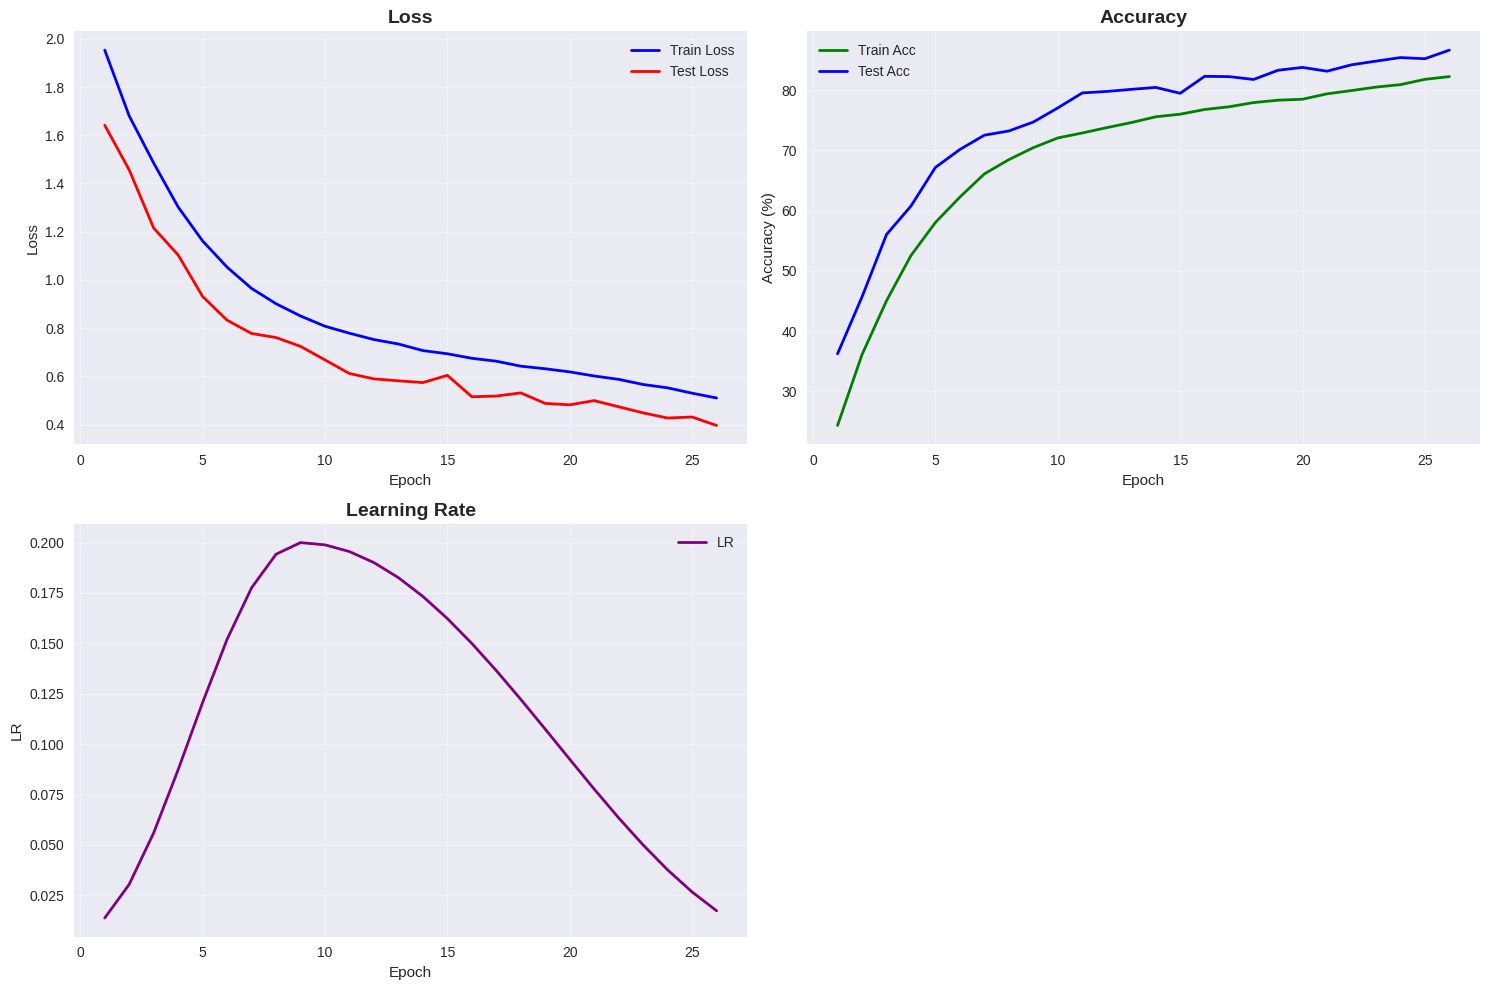

In [11]:
# Visualize curves
visualizer = create_visualizer(config.visualization)
visualizer.plot_training_curves(
    metrics.train_losses,
    metrics.train_accuracies,
    metrics.learning_rates,
    None,  # or provide a save path like 'training_curves.png'
    metrics.test_accuracies,
    metrics.test_losses,
)



## Analysis: Per-Class Accuracy and Misclassifications


Calculating per-class accuracy...


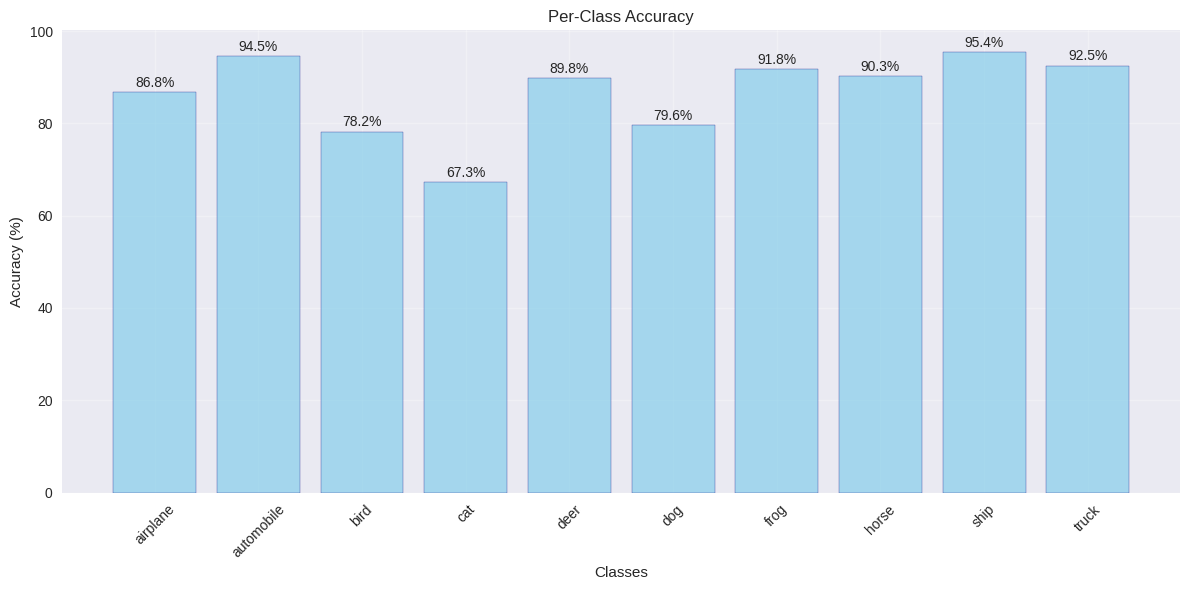

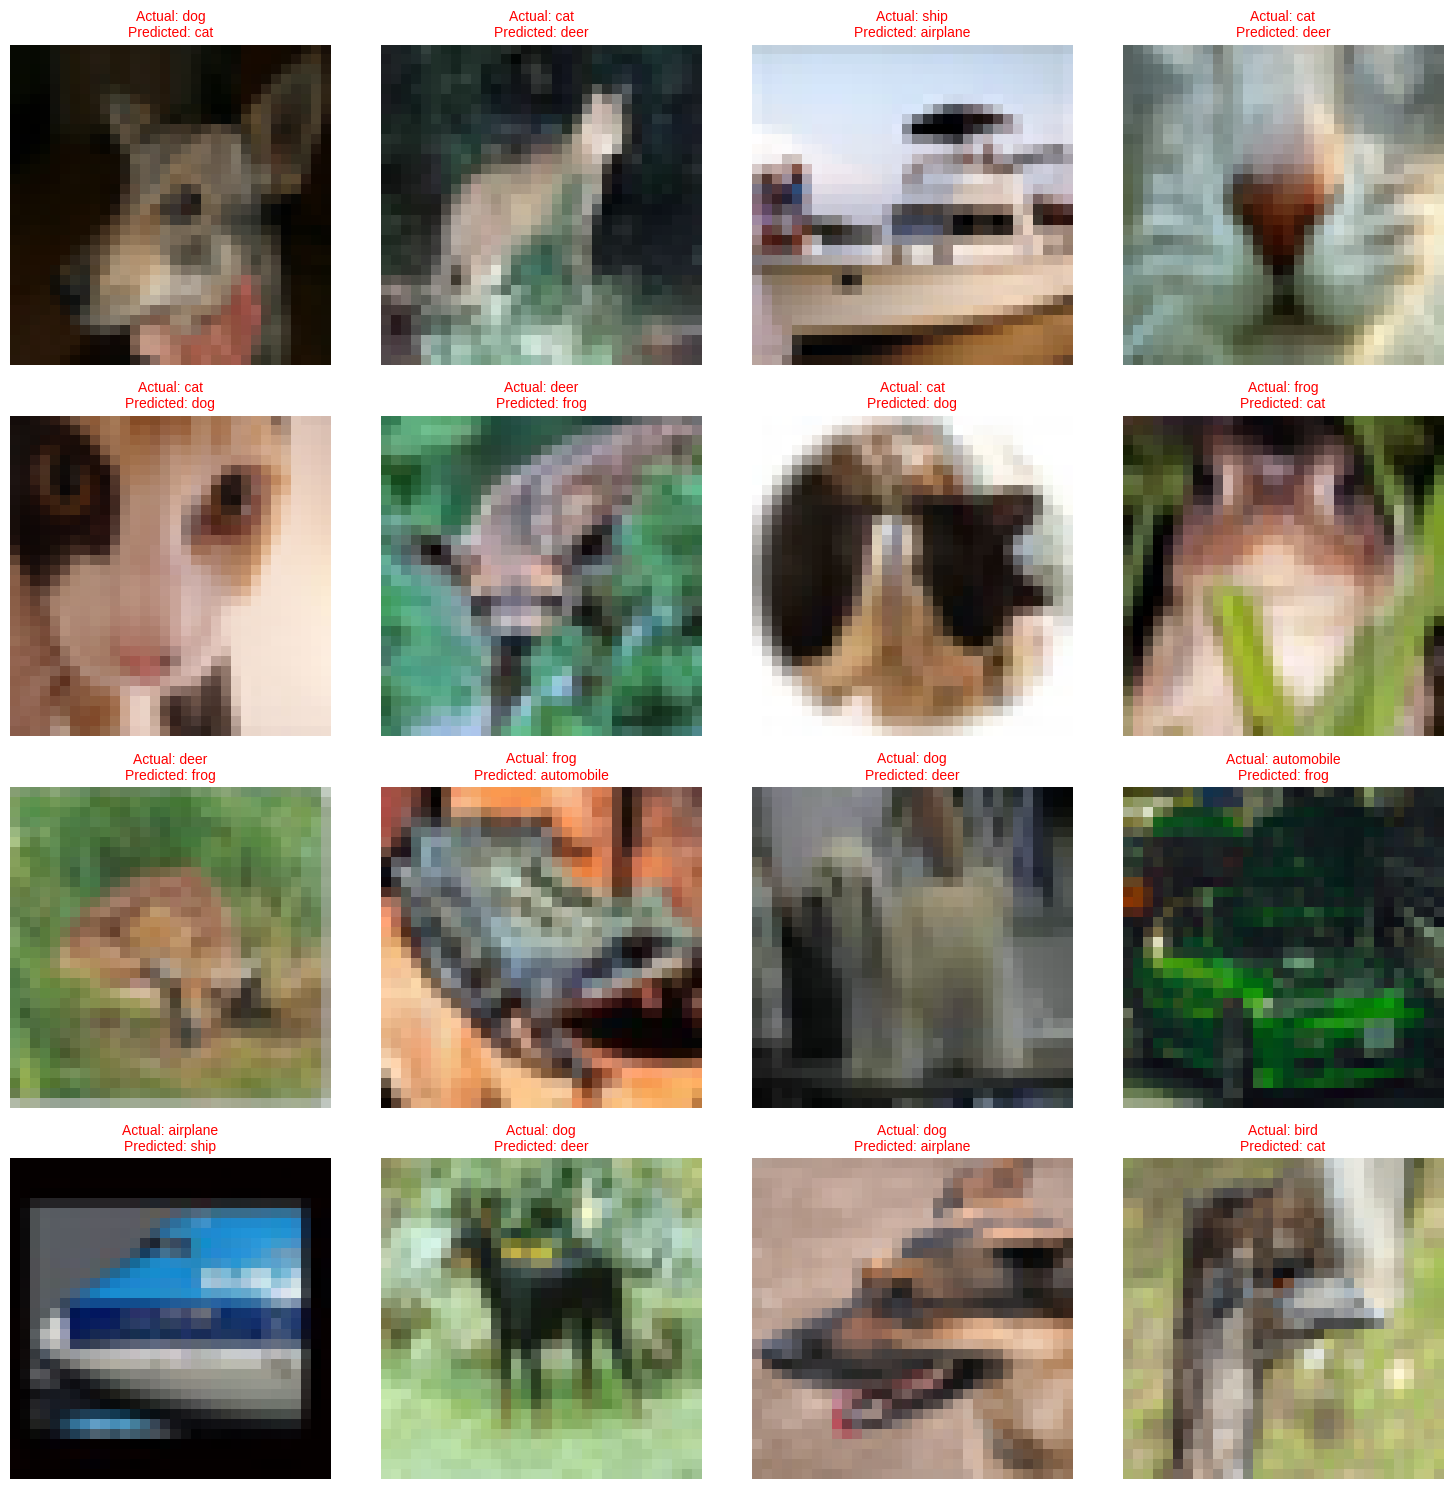

Displayed 16 misclassified images


In [12]:
# Optional: visualize per-class accuracy and misclassified images
from src.data.data_manager import CIFAR10DataManager
class_names = train_ds.classes

# Per-class accuracy
_ = visualizer.plot_per_class_accuracy(model, test_loader, class_names, device)

# Misclassified images
visualizer.analyze_misclassified_images(model, test_loader, class_names, device=device, num_images=16)


In [13]:
# Final analysis
best_metrics = metrics.get_best_metrics()

print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print(f"Best validation accuracy: {best_metrics['best_val_accuracy']:.2f}%")
print(f"Best epoch: {best_metrics['best_epoch']}")
print(f"Target accuracy: {config.training.target_accuracy}%")
print(f"Target achieved: {'✓' if best_metrics['best_val_accuracy'] >= config.training.target_accuracy else '✗'}")

print(f"\nModel Architecture Compliance:")
print(f"✓ C1C2C3C40 structure: Implemented")
print(f"✓ No MaxPooling: Implemented")
print(f"✓ Stride=2 in Conv Block 4: Implemented")
print(f"✓ Depthwise Separable Convolution: Implemented")
print(f"✓ Dilated Convolution: Implemented")
print(f"✓ Global Average Pooling: Implemented")
print(f"✓ FC layer after GAP: Implemented")
print(f"✓ Albumentation augmentations: Implemented")

print(f"\nParameter count: {total_params:,} (< {config.model.max_parameters:,} requirement: {'✓' if total_params < config.model.max_parameters else '✗'})")
print(f"Receptive Field: > 44 (requirement: ✓)")

print(f"\nData Augmentation Applied:")
print(f"✓ Horizontal Flip: p={config.data.horizontal_flip_prob}")
print(f"✓ ShiftScaleRotate: p={config.data.shift_scale_rotate_prob}")
print(f"✓ CoarseDropout: p={config.data.coarse_dropout_prob}")

print("\n✅ Training completed successfully!")
print("=" * 60)


FINAL RESULTS SUMMARY
Best validation accuracy: 86.62%
Best epoch: 26
Target accuracy: 85.0%
Target achieved: ✓

Model Architecture Compliance:
✓ C1C2C3C40 structure: Implemented
✓ No MaxPooling: Implemented
✓ Stride=2 in Conv Block 4: Implemented
✓ Depthwise Separable Convolution: Implemented
✓ Dilated Convolution: Implemented
✓ Global Average Pooling: Implemented
✓ FC layer after GAP: Implemented
✓ Albumentation augmentations: Implemented

Parameter count: 162,458 (< 200,000 requirement: ✓)
Receptive Field: > 44 (requirement: ✓)

Data Augmentation Applied:
✓ Horizontal Flip: p=0.5
✓ ShiftScaleRotate: p=0.5
✓ CoarseDropout: p=0.3

✅ Training completed successfully!
